In [3]:
import pandas as pd
import scipy.io

mat = scipy.io.loadmat('data-8.mat')  

label_map = ['2ASK', '2FSK', '2PSK', '4ASK', '4FSK', '4PSK', '8ASK', '8FSK', '8PSK', '16QAM', '64QAM']
label_map = dict(zip(range(11), label_map))
label_map

{0: '2ASK',
 1: '2FSK',
 2: '2PSK',
 3: '4ASK',
 4: '4FSK',
 5: '4PSK',
 6: '8ASK',
 7: '8FSK',
 8: '8PSK',
 9: '16QAM',
 10: '64QAM'}

In [4]:
# As 963 amostras temporais vem na forma colunar, gostaríamos de colocá-los por linhas, 
# este passo então irá colocar a cada linha uma amostra do sinal temporal, bem como sua categoria

all_dfs = []
for i in range(22000):
    df = pd.DataFrame(mat['Qt'][0][i][0], columns = ['realizations', 'labels']).T
    df['label'] = df.loc['labels'][0]
    df = df.drop(['labels'], axis=0)
    all_dfs.append(df)

In [5]:
data = pd.concat(all_dfs)
data = data.reset_index(drop=True)

In [6]:
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,951,952,953,954,955,956,957,958,959,label
0,0.820464,0.726486,0.510712,0.343558,0.290709,0.366247,0.517827,0.752709,0.779955,0.719940,...,0.748857,0.754128,0.713617,0.521617,0.371254,0.236886,0.299190,0.522693,0.726867,0.0
1,0.807467,0.619497,0.618561,0.675334,0.448838,0.431104,0.317677,0.481104,0.249112,0.320491,...,0.605159,0.714560,0.685380,0.609706,0.322134,0.220908,0.240624,0.565649,0.657717,1.0
2,0.246404,0.371717,0.555008,0.618323,0.580389,0.664642,0.563636,0.343797,0.229394,0.270854,...,0.776534,0.761257,0.690087,0.500493,0.285487,0.264822,0.281686,0.462832,0.615862,2.0
3,0.684792,0.549584,0.510974,0.393616,0.387274,0.522693,0.638008,0.568677,0.548238,0.578292,...,0.685379,0.559858,0.587314,0.460903,0.391586,0.375129,0.457790,0.626912,0.496669,3.0
4,0.624828,0.826303,0.634223,0.650169,0.615344,0.425413,0.502878,0.397682,0.295608,0.402082,...,0.710602,0.548100,0.739188,0.516816,0.327807,0.360805,0.333105,0.511796,0.670320,4.0


In [7]:
X = data[[col for col in data.columns if col!='label']]
y = data.label

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)
X_train.shape, X_test.shape

((11000, 960), (11000, 960))

In [8]:
import torch
import torch.utils.data
import numpy as np

train = torch.tensor(X_train.values.astype(np.float32))
train_target = torch.tensor(y_train.values.astype(np.float32))
train_target = train_target.type(torch.LongTensor)

test = torch.tensor(X_test.values.astype(np.float32))
test_target = torch.tensor(y_test.values.astype(np.float32))
test_target = test_target.type(torch.LongTensor)

train_tensor = torch.utils.data.TensorDataset(train, train_target) 
test_tensor = torch.utils.data.TensorDataset(test, test_target) 

trainloader = torch.utils.data.DataLoader(dataset=train_tensor, 
                                          batch_size=64, shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_tensor, 
                                          batch_size=64, shuffle=True)

In [9]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(960, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 11)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

model = Classifier()
print(model)
model.cuda()

Classifier(
  (fc1): Linear(in_features=960, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=11, bias=True)
)


Classifier(
  (fc1): Linear(in_features=960, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=11, bias=True)
)

In [10]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
valid_loss_min = np.Inf
train_losses, test_losses = [], []
epochs = 100

for e in range(epochs):
    accuracy = 0
    running_loss = 0
    for x, labels in trainloader:
        
        x, labels = x.cuda(), labels.cuda()
        optimizer.zero_grad()
        
        log_ps = model(x)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()    
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        print('Loss for training is {} in epoch {}'.format(running_loss / len(trainloader), e))
        with torch.no_grad():
            running_loss_test = 0
            for x, labels in testloader:
                x, labels = x.cuda(), labels.cuda()
                output = model(x)
                loss = criterion(output, labels)
                running_loss_test += loss
                
                ps = torch.exp(output)
                
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)

                accuracy += torch.mean(equals.type(torch.FloatTensor))
        accuracy /= len(testloader)
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(running_loss_test / len(testloader))
        print('Loss for test is {} in epoch {}'.format(running_loss_test / len(testloader), e))
        print(f'Accuracy: {accuracy.item()*100}%')

Loss for training is 1.5329083006742388 in epoch 0
Loss for test is 1.146957278251648 in epoch 0
Accuracy: 45.193102955818176%
Loss for training is 1.0680738261272742 in epoch 1
Loss for test is 1.043029546737671 in epoch 1
Accuracy: 49.781978130340576%
Loss for training is 1.0357938672220983 in epoch 2
Loss for test is 1.0699043273925781 in epoch 2
Accuracy: 47.96381592750549%
Loss for training is 1.0283706725336785 in epoch 3
Loss for test is 1.130159854888916 in epoch 3
Accuracy: 43.92390251159668%
Loss for training is 1.0157077260488687 in epoch 4
Loss for test is 1.0907396078109741 in epoch 4
Accuracy: 46.48697078227997%
Loss for training is 1.0069099134484003 in epoch 5
Loss for test is 1.021465539932251 in epoch 5
Accuracy: 47.84572124481201%
Loss for training is 1.00520032609618 in epoch 6
Loss for test is 1.019060730934143 in epoch 6
Accuracy: 50.62681436538696%
Loss for training is 1.004444145186003 in epoch 7
Loss for test is 1.016803503036499 in epoch 7
Accuracy: 50.1116037

Loss for training is 0.842671925591868 in epoch 64
Loss for test is 0.9755412340164185 in epoch 64
Accuracy: 55.909985303878784%
Loss for training is 0.832935894297999 in epoch 65
Loss for test is 0.9870063662528992 in epoch 65
Accuracy: 55.420732498168945%
Loss for training is 0.8338469457487727 in epoch 66
Loss for test is 0.9999377131462097 in epoch 66
Accuracy: 54.14243936538696%
Loss for training is 0.8327553743539855 in epoch 67
Loss for test is 0.9599698185920715 in epoch 67
Accuracy: 56.54329061508179%
Loss for training is 0.8097310953362044 in epoch 68
Loss for test is 0.959172785282135 in epoch 68
Accuracy: 58.049988746643066%
Loss for training is 0.8260999720456988 in epoch 69
Loss for test is 0.9524623155593872 in epoch 69
Accuracy: 58.03960561752319%
Loss for training is 0.8012894662313683 in epoch 70
Loss for test is 0.9724074006080627 in epoch 70
Accuracy: 58.31732749938965%
Loss for training is 0.8063105386356975 in epoch 71
Loss for test is 0.9316537380218506 in epoch 

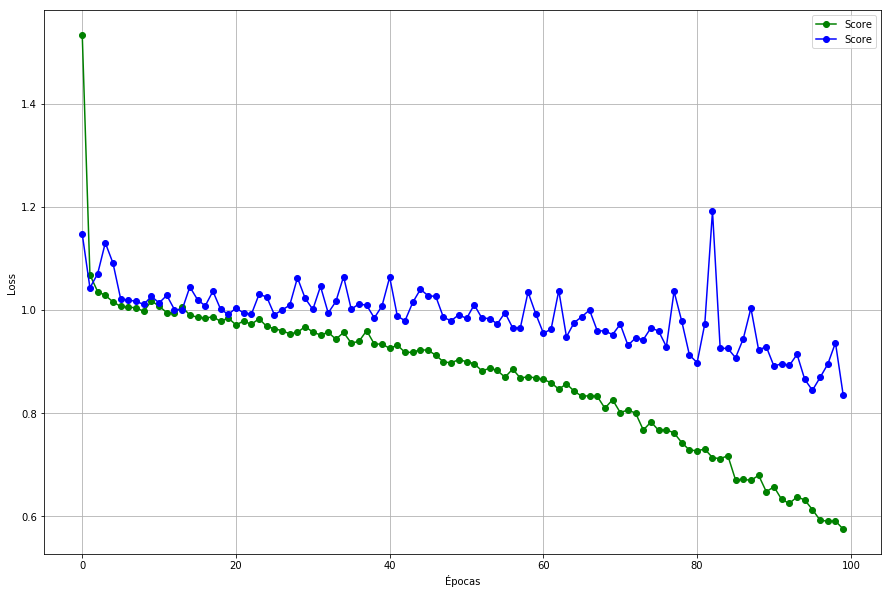

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots()

ax.plot(list(range(len(train_losses))), train_losses, 'g-o', label = 'Score')
ax.plot(list(range(len(test_losses))), test_losses, 'b-o', label = 'Score', )
ax.legend()
ax.set_xlabel('Épocas')
ax.set_ylabel('Loss')
ax.grid()

fig.set_figheight(10)
fig.set_figwidth(15)

In [12]:
scores_nn = {}
scores_nn['0'] = 0.74
scores_nn['4'] = 0.73
scores_nn['8'] = 0.77
scores_nn['12'] = 0.75
scores_nn['16'] = 0.78
scores_nn['20'] = 0.79

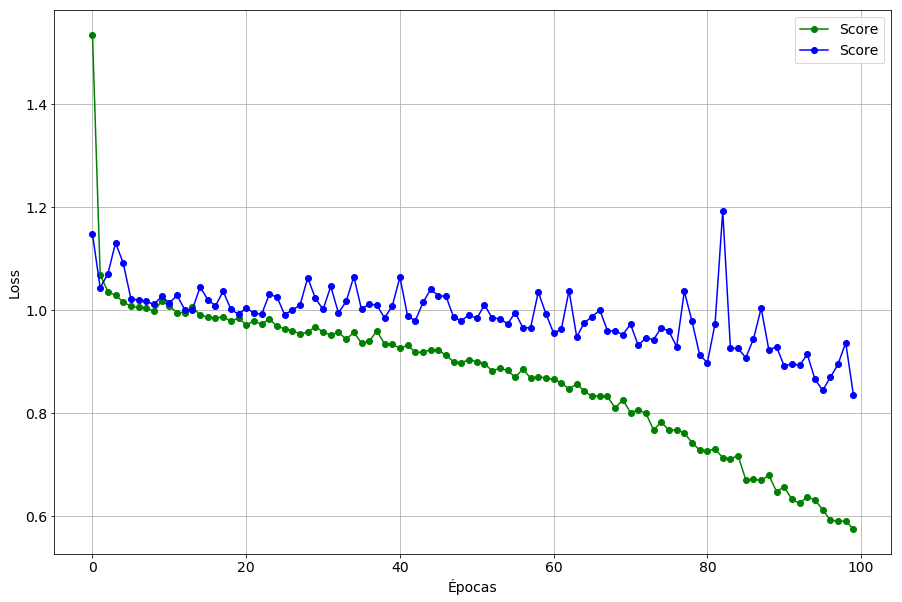

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.plot(list(range(len(train_losses))), train_losses, 'g-o', label = 'Score')
ax.plot(list(range(len(test_losses))), test_losses, 'b-o', label = 'Score', )
ax.legend()
ax.set_xlabel('Épocas')
ax.set_ylabel('Loss')
ax.grid()

fig.set_figheight(10)
fig.set_figwidth(15)